### Imports

In [18]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "species")
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

print("DATA_DIR:", DATA_DIR)

DATA_DIR: C:\Users\user\Desktop\plant-project\plant-ai\data\species


### Class Overview

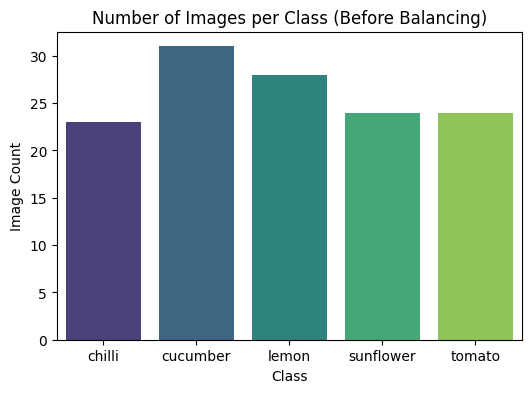

,Class,Image Count
0,chilli,23
1,cucumber,31
2,lemon,28
3,sunflower,24
4,tomato,24


In [36]:
# Count number of images per class
species_classes = sorted(os.listdir(DATA_DIR))
data_counts = {cls: len(os.listdir(os.path.join(DATA_DIR, cls))) for cls in species_classes}

df_counts = pd.DataFrame(list(data_counts.items()), columns=["Class", "Image Count"])
plt.figure(figsize=(6,4))
sns.barplot(data=df_counts, x="Class", y="Image Count", hue="Class", dodge=False, palette="viridis", legend=False)
plt.title("Number of Images per Class (Before Balancing)")
plt.show()

df_counts

### Preview Images

Species: ['chilli', 'cucumber', 'lemon', 'sunflower', 'tomato']


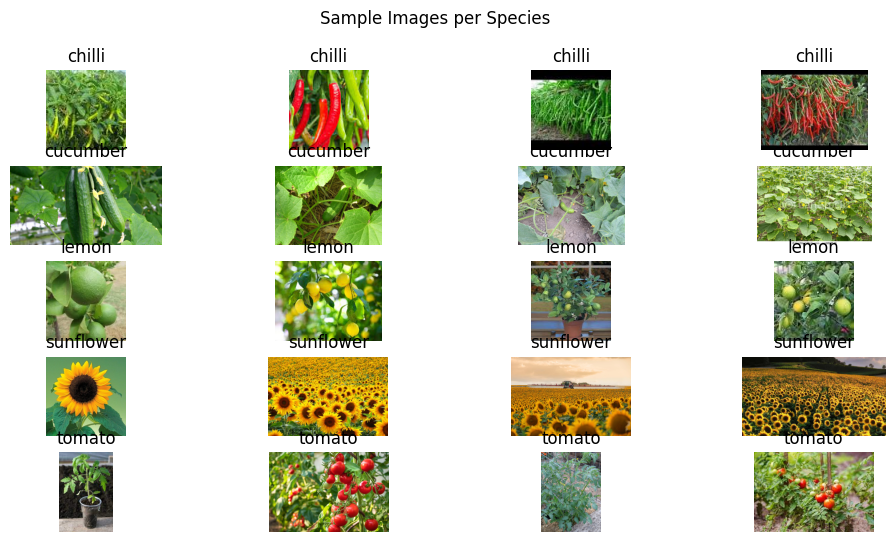

In [20]:
import glob
from PIL import Image

species_classes = sorted(os.listdir(DATA_DIR))
print("Species:", species_classes)

def sample_images(label, n=4):
    folder = os.path.join(DATA_DIR, label)
    files = glob.glob(folder + "/*")
    files = random.sample(files, min(n, len(files)))
    return [Image.open(f) for f in files]

plt.figure(figsize=(12,6))
for i, label in enumerate(species_classes):
    imgs = sample_images(label)
    for j, img in enumerate(imgs):
        plt.subplot(len(species_classes), 4, i*4 + j + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
plt.suptitle("Sample Images per Species")
plt.show()

### Dataset splitting

In [21]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

species_classes = train_ds.class_names
print("Classes:", species_classes)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 130 files belonging to 5 classes.
Using 104 files for training.
Found 130 files belonging to 5 classes.
Using 26 files for validation.
Classes: ['chilli', 'cucumber', 'lemon', 'sunflower', 'tomato']


### Model

In [22]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])(inputs)

x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(species_classes), activation="softmax")(x)

species_model = tf.keras.Model(inputs, outputs)
species_model.compile(optimizer="adam",
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])

species_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_2 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_2 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train

In [27]:
EPOCHS = 15
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
history = species_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 663ms/step - accuracy: 0.8558 - loss: 0.5532 - val_accuracy: 0.8846 - val_loss: 0.5676
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 509ms/step - accuracy: 0.9231 - loss: 0.4523 - val_accuracy: 0.9615 - val_loss: 0.4478
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.8846 - loss: 0.4772 - val_accuracy: 0.9615 - val_loss: 0.3756
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - accuracy: 0.9519 - loss: 0.3367 - val_accuracy: 1.0000 - val_loss: 0.3356
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - accuracy: 0.9423 - loss: 0.2872 - val_accuracy: 0.9615 - val_loss: 0.2954
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 603ms/step - accuracy: 0.9423 - loss: 0.2380 - val_accuracy: 0.9615 - val_loss: 0.2699
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 637ms/step - accuracy: 0.9423 - loss: 0.2434 - val_accuracy: 0.9615 - val_loss: 0.2548


### Training Curves

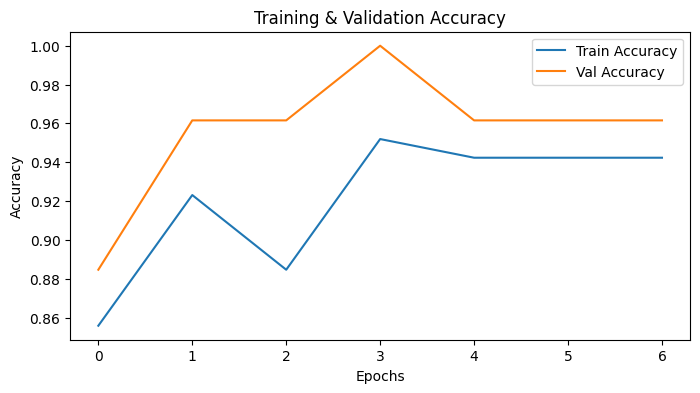

In [28]:
plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
Classification Report:
              precision    recall  f1-score   support

      chilli       1.00      1.00      1.00         1
    cucumber       1.00      1.00      1.00         5
       lemon       1.00      1.00      1.00         6
   sunflower       1.00      1.00      1.00         7
      tomato       1.00      1.00      1.00         7

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



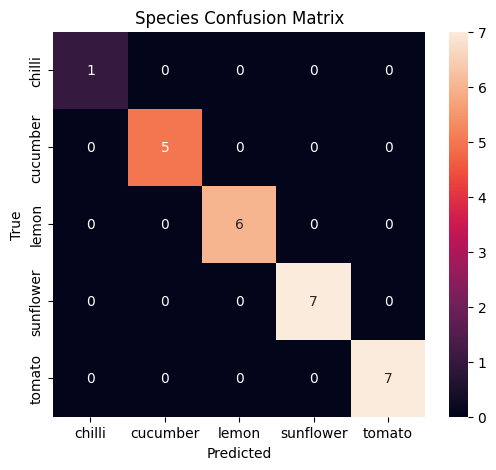

In [29]:
y_true = []
y_pred = []

for imgs, labels in val_ds:
    preds = species_model.predict(imgs)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=species_classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, xticklabels=species_classes, yticklabels=species_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Species Confusion Matrix")
plt.show()

### Sample Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


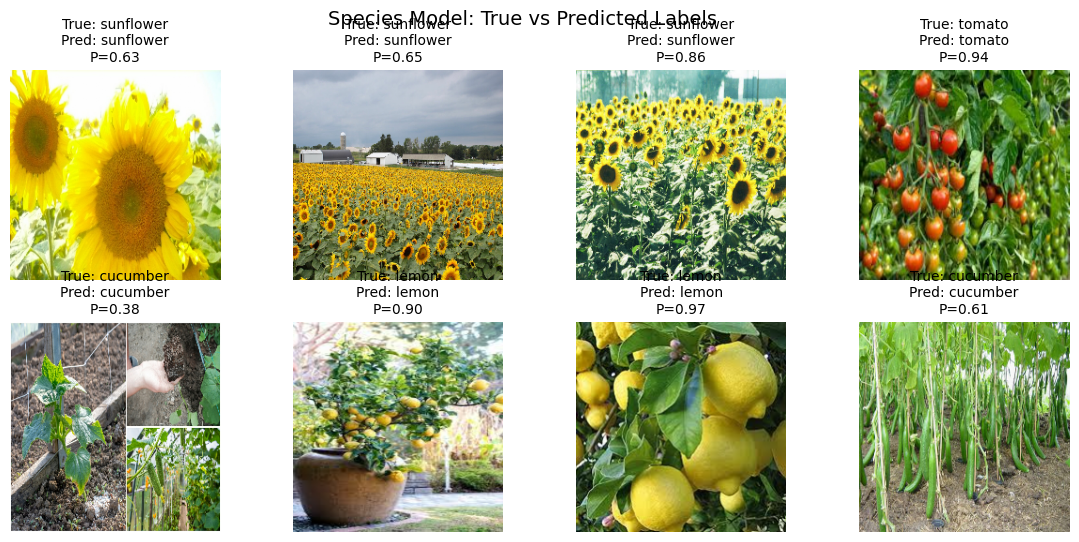

In [33]:
for images, labels in val_ds.take(1):
    preds = species_model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    probs = np.max(preds, axis=1)
    imgs = images.numpy()
    true_labels = labels.numpy()
    break

n = min(8, imgs.shape[0])
plt.figure(figsize=(14,6))
for i in range(n):
    plt.subplot(2,4,i+1)
    plt.imshow(imgs[i] / 255.0)  # ✅ fix for clipping warning
    title = f"True: {species_classes[true_labels[i]]}\nPred: {species_classes[preds_labels[i]]}\nP={probs[i]:.2f}"
    plt.title(title, fontsize=10)
    plt.axis('off')
plt.suptitle("Species Model: True vs Predicted Labels", fontsize=14)
plt.show()

### Save model & metadata

In [37]:
import json

model_path = os.path.join(MODEL_DIR, "species_model.keras")
species_model.save(model_path)
print("Saved:", model_path)

with open(os.path.join(MODEL_DIR, "species_classes.json"), "w") as f:
    json.dump(species_classes, f)
print("Saved species classes.")

Saved: C:\Users\user\Desktop\plant-project\plant-ai\models\species_model.keras
Saved species classes.
